Hello
Below you will find a tutorial on how to use ATLAS_Parser - a tool made for working with ATLAS Open Data

We will start by importing and initializing configurations

In [ ]:
#Import the tools
from src.parse_atlas import parser
from src.calculations import physics_calcs, combinatorics
import math, awkward as ak, numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
#Configurations
config_parser = {
    "max_process_memory_mb": 8192,
    "max_chunk_size_bytes": 500_000_000,
    "max_threads": 3,
    "release_year": "2024",
    "file_limit": 5,
    "logging_path": "tutorial/logs/",
    "output_path": "tutorial/data/root_files/",
    "initialize_statistics": True
}

config_kinematic_cuts = {
    "pt":{"min": 0},
    "eta":{"min": -5,"max": 5},
    "phi":{"min": -math.pi, "max": math.pi}
}

config_particle_counts = {
    "Electrons" : {"min":1, "max": 6},
    "Jets" : {"min":2, "max": 8},
    "Muons" : {"min":1, "max": 6},
    "Photons" : {"min":0, "max": 5}
}

Start by initilazing the ATLAS_Parser class and fetch record ids for records released in year 2024

In [3]:
#Initializing the parser with configuration
atlasparser = parser.ATLAS_Parser(
        max_process_memory_mb=config_parser["max_process_memory_mb"],
        max_chunk_size_bytes=config_parser["max_chunk_size_bytes"],
        max_threads=config_parser["max_threads"],
        logging_path=config_parser["logging_path"],
        initialize_statistics=config_parser["initialize_statistics"]
        )

#Fetching file URIs for a specified release year
release_files_uris = atlasparser.fetch_records_ids(
    release_year=config_parser["release_year"]
)

Now using these record ids we can parse using parse_files
Apply cuts and filters
And save the output

Using ATLAS_Parser class and physics_calcs

In [4]:
for events_chunk in atlasparser.parse_files(
    files_ids=release_files_uris, 
    limit=config_parser["file_limit"]
):
    #Here you can do stuff with events_chunk
    #Below you can find an example pipeline that processes the events
    
    #Cutting by kinematics
    cut_events = physics_calcs.filter_events_by_kinematics(
        events_chunk, config_kinematic_cuts
    ) 

    #Filtering events by amounts of each particle
    filtered_events = physics_calcs.filter_events_by_particle_counts(
        events=cut_events, 
        particle_counts=config_particle_counts, 
        is_particle_counts_range=True
    ) 

    #Prepare the events array for ROOT format
    root_ready = atlasparser.flatten_for_root(filtered_events)

    #Save the file
    atlasparser.save_events_as_root(root_ready, config_parser["output_path"])

Starting to parse 5 files with 3 threads.


Parsing files:   0%|          | 0/5 [00:00<?, ?file/s]


Parsing file: 100%|██████████| 1/1 [00:00<00:00,  1.08batch/s]
                                                      

                                                


Parsing files:   0%|          | 0/5 [00:03<?, ?file/s]


                                                      

                                                


Parsing files:   0%|          | 0/5 [00:03<?, ?file/s]


Parsing files:  20%|██        | 1/5 [00:03<00:13,  3.44s/file, ✅ 1 | ❌ 0 | ✨ 100.0% | 💾 0.9 MB | 🎯 10,374 events]

✅ File processed: 0.94 MB logical size, 10,374 events.
166.6 MB used after parsing 1 files.



Parsing file: 100%|██████████| 1/1 [00:01<00:00,  1.14s/batch]
                                                                                                                      


Parsing files:  20%|██        | 1/5 [00:03<00:13,  3.44s/file, ✅ 1 | ❌ 0 | ✨ 100.0% | 💾 0.9 MB | 🎯 10,374 events]

                                                                                                                      


Parsing files:  20%|██        | 1/5 [00:03<00:13,  3.44s/file, ✅ 1 | ❌ 0 | ✨ 100.0% | 💾 0.9 MB | 🎯 10,374 events]

                                                                                                                      


Parsing files:  20%|██        | 1/5 [00:03<00:13,  3.44s/file, ✅ 1 | ❌ 0 | ✨ 100.0% | 💾 0.9 MB | 🎯 10,374 events]

Parsing files:  20%|██        | 1/5 [00:03<00:13,  3.44s/file, ✅ 2 | ❌ 0 | ✨ 100.0% | 💾 1.6 MB | 🎯 28,945 events]

✅ File processed: 0.37 MB logical size, 18,571 events.
⚠️  High memory growth: 2.1 MB for 0.7 MB file
174.6 MB used after parsing 2 files.




Parsing files:  40%|████      | 2/5 [00:03<00:10,  3.44s/file, ✅ 3 | ❌ 0 | ✨ 100.0% | 💾 3.1 MB | 🎯 45,870 events]   

✅ File processed: 1.48 MB logical size, 16,925 events.
184.7 MB used after parsing 3 files.



Parsing file: 100%|██████████| 1/1 [00:00<00:00,  1.08batch/s]
                                                                                                                      

Parsing files:  60%|██████    | 3/5 [00:05<00:06,  3.44s/file, ✅ 3 | ❌ 0 | ✨ 100.0% | 💾 3.1 MB | 🎯 45,870 events]
                                                                                                                      

Parsing files:  80%|████████  | 4/5 [00:05<00:01,  1.31s/file, ✅ 4 | ❌ 0 | ✨ 100.0% | 💾 4.2 MB | 🎯 57,769 events]

✅ File processed: 1.08 MB logical size, 11,899 events.
212.1 MB used after parsing 4 files.



Parsing files: 100%|██████████| 5/5 [00:06<00:00,  1.26s/file, ✅ 5 | ❌ 0 | ✨ 100.0% | 💾 4.9 MB | 🎯 66,160 events]   


✅ File processed: 0.76 MB logical size, 8,391 events.
216.4 MB used after parsing 5 files.

📊 ATLAS PARSING STATISTICS SUMMARY
⏱️  Total Time: 6.4s
📁 Files: ✅5 / ❌0 / 📊5
✨ Success Rate: 100.0%
💾 Data Processed: 4.9 MB
🎯 Events Processed: 66,160
📦 Chunks Created: 0
📊 Max memory captured: 0.0 MB
📋 Full stats saved to: tutorial/logs/atlas_stats.json


Now that we parsed the files we can use them
Below is an example for a pipeline that calculates the events' invariant masses.

In [5]:
config_inv_mass_calc = {
   "input_dir": "tutorial/data/root_files",
   "output_dir": "tutorial/data/inv_masses",
   "objects_to_calculate": [
       "Electrons",
       "Muons",
       "Jets",
       "Photons"
   ]
}

In [8]:
def calculate_masses(combinations):
    for filename in os.listdir(config_inv_mass_calc["input_dir"]):
        if filename.endswith(".root"):
            file_path = os.path.join(config_inv_mass_calc["input_dir"], filename)
            
            particle_arrays: ak.Array = parser.ATLAS_Parser.parse_file(file_path)

            for combination in combinations:  # Limit to first 5 combinations for testing
                filtered_events: ak.Array = physics_calcs.filter_events_by_particle_counts(
                    events=particle_arrays, 
                    particle_counts=combination, 
                    is_particle_counts_range=False
                )    
                
                if len(filtered_events) == 0:
                    continue
                
                inv_mass: list = physics_calcs.calc_inv_mass(filtered_events) 
                
                if not ak.any(inv_mass):
                    continue

                combination_name = prepare_combination_name(combination)
                output_path = os.path.join(
                    config_inv_mass_calc["output_dir"], 
                    f"{filename}_{combination_name}_inv_mass.npy" 
                    )
                
                np.save(output_path, ak.to_numpy(inv_mass))

def prepare_combination_name(combination: dict) -> str:
    combination_name = ''
    for object, amount in combination.items():
        combination_name += str(amount)
        combination_name += object[0].lower()

    return combination_name

os.makedirs(config_inv_mass_calc["output_dir"], exist_ok=True)
    
all_combinations = combinatorics.get_all_combinations(
    config_inv_mass_calc["objects_to_calculate"], 
    limit=50)

calculate_masses(all_combinations)

Parsing file: 100%|██████████| 1/1 [00:00<00:00, 61.82batch/s]


Now we have invariant masses for all of the combinations calculated (here they are limited to 30 but it is configruable)

Let's create a histogram with the biggest invariant mass we have

Chosen largest file: 5de979b525e15515.root_1e1m3j_inv_mass.npy (51728 bytes)
Number of events: 6450
Mean invariant mass: 266516.17
Median invariant mass: 201951.86
Standard deviation: 210189.76
Minimum invariant mass: 31117.69
Maximum invariant mass: 2153476.60


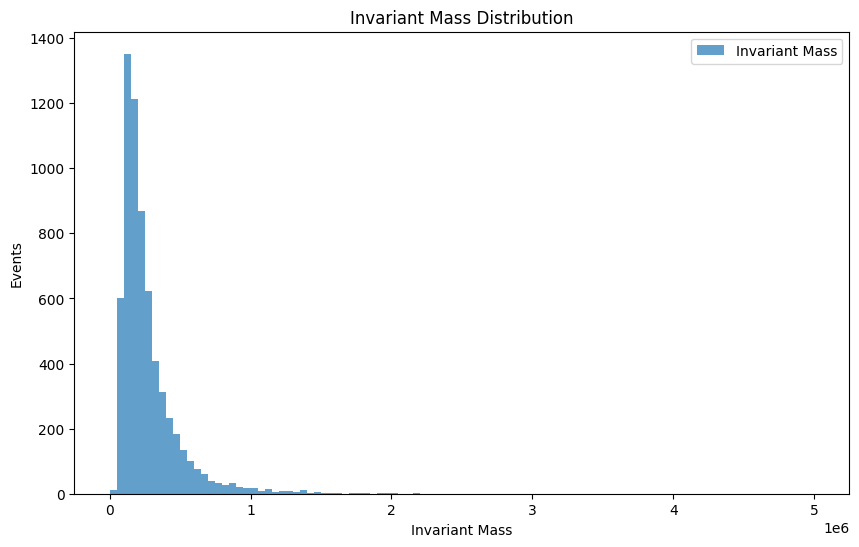

In [ ]:
inv_masses_raw = [f for f in os.listdir(config_inv_mass_calc["output_dir"]) if f.endswith(".npy")]
inv_masses_sizes = {f: os.path.getsize(os.path.join(config_inv_mass_calc["output_dir"], f)) for f in inv_masses_raw}
biggest_file = max(inv_masses_sizes, key=inv_masses_sizes.get)
print(f"Chosen largest file: {biggest_file} ({inv_masses_sizes[biggest_file]} bytes)")

biggest_file_path = os.path.join(config_inv_mass_calc["output_dir"], biggest_file)
inv_masses = np.load(biggest_file_path)

# Create histogram
n_bins = 100  # Adjust based on your needs
mass_min, mass_max = 0, 5000000  # Adjust range as needed

bin_content, bin_edges = np.histogram(inv_masses, bins=n_bins, range=(mass_min, mass_max))
bin_errors = np.sqrt(bin_content)  # Poisson errors

print(f"Number of events: {len(inv_masses)}")
print(f"Mean invariant mass: {np.mean(inv_masses):.2f}")
print(f"Median invariant mass: {np.median(inv_masses):.2f}")
print(f"Standard deviation: {np.std(inv_masses):.2f}")
print(f"Minimum invariant mass: {np.min(inv_masses):.2f}")
print(f"Maximum invariant mass: {np.max(inv_masses):.2f}")
plt.figure(figsize=(10,6))
plt.hist(bin_edges[:-1], bins=bin_edges, weights=bin_content, alpha=0.7, label='Invariant Mass')
plt.xlabel('Invariant Mass')
plt.ylabel('Events')
plt.title('Invariant Mass Distribution')
plt.legend()
plt.show()

Now let's see the top 9 biggest side by side

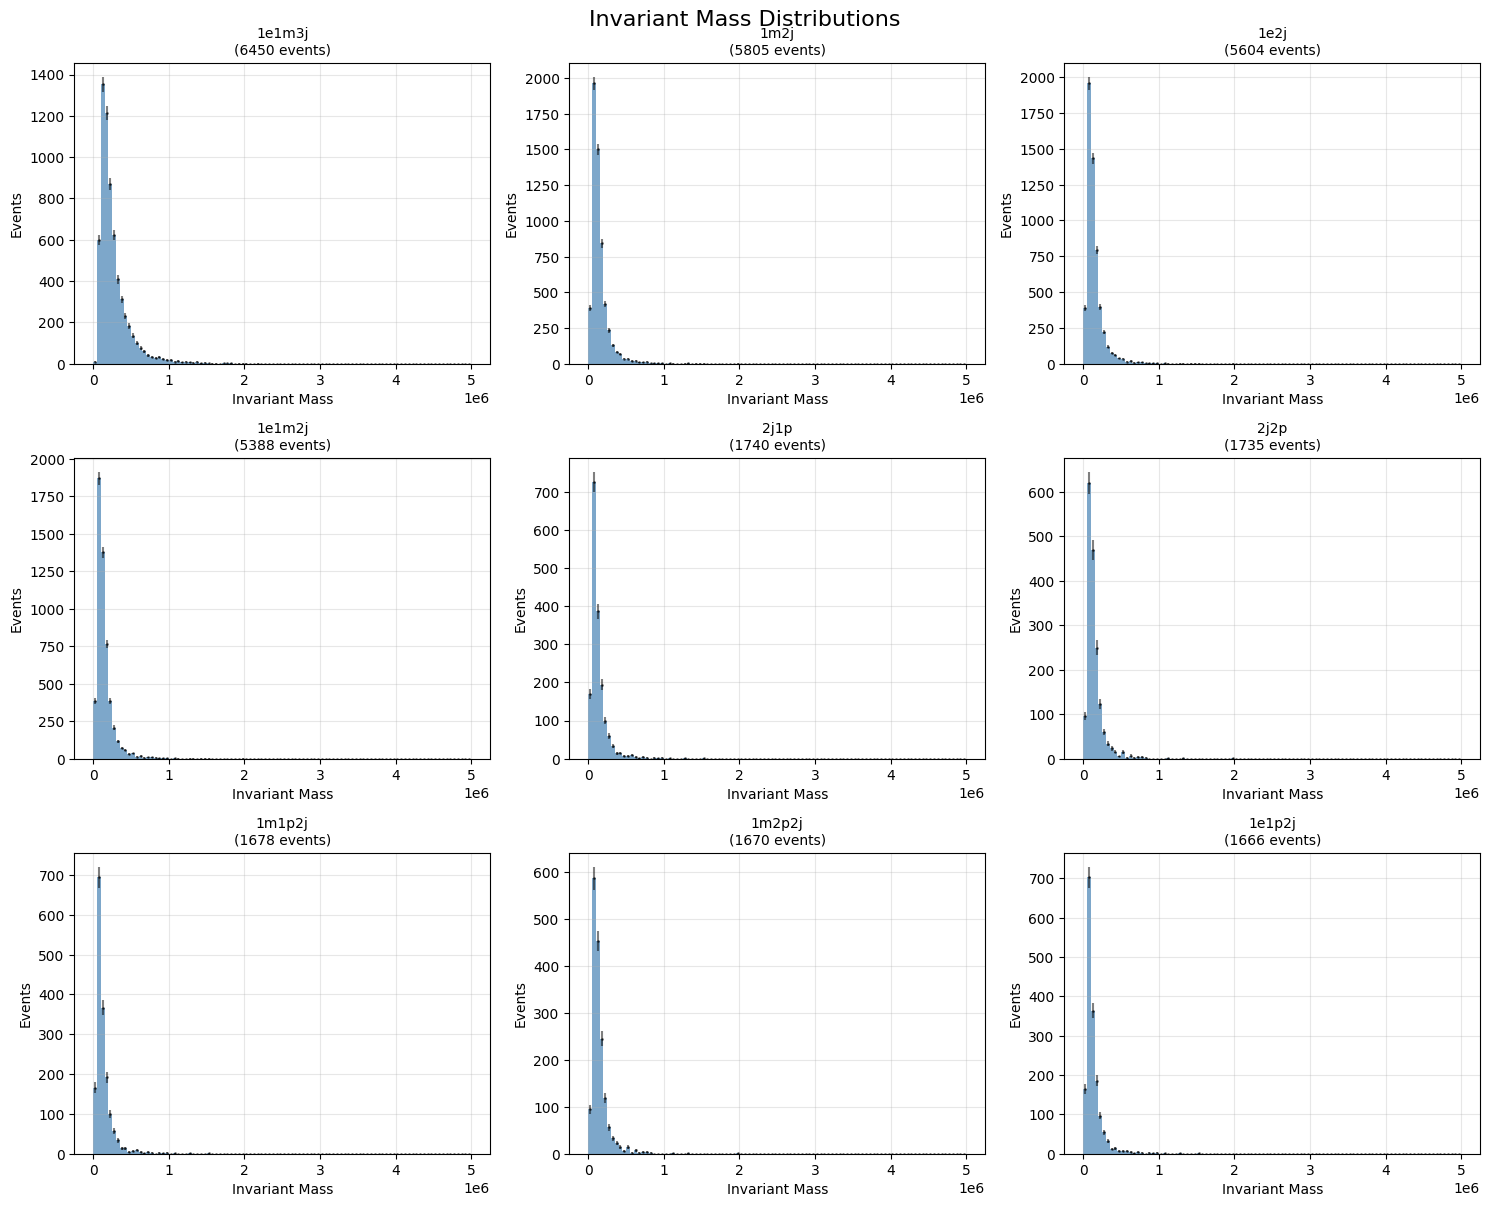

In [16]:
# Get all .npy files
inv_masses_raw = [f for f in os.listdir(config_inv_mass_calc["output_dir"]) if f.endswith(".npy")]
inv_masses_sizes = {f: os.path.getsize(os.path.join(config_inv_mass_calc["output_dir"], f)) for f in inv_masses_raw}

# Sort files by size and take the 9 largest
sorted_files = sorted(inv_masses_sizes.items(), key=lambda x: x[1], reverse=True)[:9]
selected_files = [f[0] for f in sorted_files]

# Histogram parameters
n_bins = 100
mass_min, mass_max = 0, 5000000

# Create 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Process each file
for idx, filename in enumerate(selected_files):
    file_path = os.path.join(config_inv_mass_calc["output_dir"], filename)
    inv_masses = np.load(file_path)
    
    # Create histogram
    bin_content, bin_edges = np.histogram(inv_masses, bins=n_bins, range=(mass_min, mass_max))
    bin_errors = np.sqrt(bin_content)
    
    # Plot on corresponding subplot
    ax = axes[idx]
    ax.hist(bin_edges[:-1], bins=bin_edges, weights=bin_content, alpha=0.7, color='steelblue')
    ax.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, bin_content, yerr=bin_errors, 
                fmt='.', color='black', alpha=0.5, markersize=2)
    
    # Extract particle combination from filename
    # Format: root_<particles>_inv_mass.npy
    particle_combo = filename.split('_inv_mass')[0].split('.root_')[1]
    
    ax.set_xlabel('Invariant Mass')
    ax.set_ylabel('Events')
    ax.set_title(f'{particle_combo}\n({len(inv_masses)} events)', fontsize=10)
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.suptitle('Invariant Mass Distributions', fontsize=16, y=1.002)
plt.show()